In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import re
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer


In [3]:
class config:
  root = "/content/drive/MyDrive/ColabNotebooks/Image-caption"
  captions_txt = os.path.join(root, 'flickr8k/captions.txt')
  images_dir = os.path.join(root, 'flickr8k/images')
  tokenizer_path = os.path.join(root, 'tokenizer.json')
  feature_extractor_path = os.path.join(root, 'feature_extractor.pkl')
  train_ratio = 0.7
  val_ratio = 0.2
  BATCH_SIZE = 32
  d_model = 512
  LR = 0.00001
  epochs = 50
  max_len = 40


# preprocessing data

In [4]:
def preprocess_caption():
  captions_path = config.captions_txt
  with open(captions_path, 'r') as f:
    next(f)
    lines = f.read()
  # name image to caption
  caption_mapping = {}
  # cleaned caption
  text_data = []
  max_caption_len = 0
  for line in lines.split('\n'):
    tokens = line.split(',')
    if len(tokens) < 2:
      continue
    image_name, caption = tokens[0], tokens[1]
    # convert to lowercase
    caption = caption.lower()
    # delete character except a-z, 0-9, space
    caption = re.sub(r"[^a-z0-9\s]", "", caption)
    # mutilple space into one
    caption = re.sub(r"\s+", " ", caption)
    caption = caption.strip()
    # delete word if it contains non-alphabetic characters
    caption = " ".join(word for word in caption.split() if word.isalpha())
    caption = " ".join(word for word in caption.split() if len(word) > 1 or word == "a")
    text_data.append(caption)
    if image_name in caption_mapping:
      caption_mapping[image_name].append(caption)
    else:
      caption_mapping[image_name] = [caption]
    # calulate max caption
    if max_caption_len < len(caption.split()):
      max_caption_len = len(caption.split())

  return caption_mapping, text_data, max_caption_len

In [5]:
caption_mapp, caption_clean, max_len = preprocess_caption()

# build tokenizer

In [8]:
def get_sentence(ds):
  for sentence in ds:
    yield sentence

def build_tokenizer(dataset):

  tokenizer_path = config.tokenizer_path
  if not os.path.exists(tokenizer_path):
    tokenizer = Tokenizer(WordLevel())
    tokenizer.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(min_frequency = 1, show_progress = True, special_tokens = ['<pad>', '<start>', '<end>'])
    tokenizer.train_from_iterator(get_sentence(dataset), trainer = trainer)
    tokenizer.save(str(tokenizer_path))

  else:
    tokenizer = Tokenizer.from_file(str(tokenizer_path))

  return tokenizer

In [9]:
tokenizer = build_tokenizer(caption_clean)

#extrac feature image using resnet

In [11]:
import pickle

In [12]:
import torch
from PIL import Image
from torchvision import transforms as T
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.models import mobilenet_v3_small,resnet18
import torch.nn as nn

In [13]:
class extractFeatureDataset():
  def __init__(self, data_imgs):
    self.data = data_imgs
    self.preprocess = T.Compose([T.Resize([224,224]),
                                T.ToTensor(),
                                T.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_name = self.data[idx]
    img_path = os.path.join(config.images_dir, img_name)
    img = Image.open(img_path)
    img_tensor = self.preprocess(img)

    return img_name, img_tensor


In [14]:
def extractFeature(data_imgs):
  """
  data_imgs: list of image names

  """
  extract_feature_path = config.feature_extractor_path
  if not os.path.exists(extract_feature_path):
    extract_dataset = extractFeatureDataset(data_imgs)
    extract_dataLoader = DataLoader(extract_dataset,batch_size = 1)
    img_features = {}
    tk = tqdm(extract_dataLoader,desc = "Extract feature image")
    cnn_model = mobilenet_v3_small(pretrained=True)
    model = nn.Sequential(*list(cnn_model.children())[:-2])
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    for img_name, img_tensor in tk:
      img_tensor = img_tensor.to(device)
      with torch.no_grad():
        # shape [1, 576, 7, 7]
        img_feature = model(img_tensor)
        img_features[img_name[0]] = img_feature
    with open(extract_feature_path, 'wb') as f:
      pickle.dump(img_features, f)
  else:
    with open(extract_feature_path, 'rb') as f:
      img_features = pickle.load(f)
  return img_features

In [15]:
all_img = list(caption_mapp.keys())
all_imgs_feature = extractFeature(all_img)

# split train, val, test

In [16]:
train_ratio = config.train_ratio
val_ratio = config.val_ratio
train_size = int(len(all_img) * train_ratio)
val_size = int(len(all_img) * val_ratio)
img_train = all_img[:train_size]
img_val = all_img[train_size:train_size+val_size]
img_test = all_img[train_size+val_size:]
print(len(img_train))
print(len(img_val))
print(len(img_test))

5663
1618
810


# create DataLoader for imagecaption model

In [17]:
class ImgCaptionDataset():
  def __init__(self, img_to_captions, data_imgs, img_encoder, tokenizer, max_seq_len):
    self.data = {image_name : img_to_captions[image_name] for image_name in data_imgs }
    self.img_encoder = img_encoder
    self.tokenizer = tokenizer
    self.max_seq = max_seq_len

    self.start_id = torch.tensor([tokenizer.token_to_id('<start>')], dtype= torch.int64)
    self.end_id = torch.tensor([tokenizer.token_to_id('<end>')], dtype= torch.int64)
    self.pad_id = torch.tensor([tokenizer.token_to_id('<pad>')], dtype= torch.int64)

  def __len__(self):
    return len(self.data.keys()) * 5

  def __getitem__(self, idx: int):

    image_index = idx // 5
    caption_index = idx % 5
    image_name = list(self.data.keys())[image_index]
    caption_text = self.data[image_name][caption_index]
    caption_ids = self.tokenizer.encode(caption_text).ids
    num_padding = self.max_seq - len(caption_ids)
    decoder_input = torch.cat([self.start_id, torch.tensor(caption_ids, dtype = torch.int64), self.end_id, torch.tensor([self.pad_id] * num_padding, dtype = torch.int64)])

    decoder_target = torch.cat([decoder_input[1:], self.pad_id])

    feature_img = self.img_encoder[image_name]
    # 1, c, h, w -> 1, h, w, c
    feature_img =  feature_img.permute(0,2,3,1)
    # 1,h,w,c-> 1, h * w, c
    feature_img = feature_img.reshape(feature_img.size(0),
                                      feature_img.size(1)*feature_img.size(2), feature_img.size(3))

    return feature_img, decoder_input, decoder_target

In [18]:
train_img_caption_dataset = ImgCaptionDataset(caption_mapp, img_train, all_imgs_feature, tokenizer, max_len)
train_img_caption_dataloader = DataLoader(train_img_caption_dataset, batch_size = config.BATCH_SIZE, shuffle = True)

In [19]:
val_img_caption_dataset = ImgCaptionDataset(caption_mapp, img_val, all_imgs_feature, tokenizer, max_len )
val_img_caption_dataloader = DataLoader(val_img_caption_dataset, batch_size = config.BATCH_SIZE, shuffle = True)

# Create model

In [21]:
import torch.nn as nn
import math

In [22]:
class PositionalEndcoding(nn.Module):
  def __init__(self, d_model: int, max_len: int, dropout:float=0.1 ):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    #caclulate 1/1000^(-2i/d_model)
    div_term = torch.exp(-(torch.arange(0, d_model, 2)/d_model)*math.log(10000))
    pos = torch.arange(max_len).unsqueeze(1) # [max_len,1]
    pos_enc = torch.zeros(max_len, 1, d_model)
    pos_enc[:, 0, 0::2] = torch.sin(pos*div_term)
    pos_enc[:, 0, 1::2] = torch.cos(pos*div_term)
    # non-parameter
    self.register_buffer('pos_enc', pos_enc)
  def forward(self, x):
    # x.shape = seq_len,batch_size, d_model
    x = x + self.pos_enc[:x.size(0)]

    return self.dropout(x)


In [23]:
class ImgCaptionModel(nn.Module):
  def __init__(self, n_head, d_model, n_layers, vocab_size, max_seq_len):
    super().__init__()
    self.pos_enc = PositionalEndcoding(d_model, max_seq_len)
    self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model = d_model, nhead = n_head)
    self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_layers)
    self.d_model = d_model
    self.embedding = nn.Embedding(vocab_size, d_model)
    self.first_layer = nn.LazyLinear(d_model)
    self.final_layer = nn.Linear(d_model, vocab_size)
    self.device = "cuda" if torch.cuda.is_available() else "cpu"

  def init_weights(self):
    initrange = 0.1
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.first_layer.bias.data.zero_()
    self.first_layer.weight.data.uniform_(-initrange, initrange)
    self.final_layer.bias.data.zero_()
    self.final_layer.weight.data.uniform_(-initrange, initrange)

  def generate_masks(self, input_decoder):
    '''
    input_decoder : batch, max_seq
    '''
    # looke-ahead, shape [max_seq, max_seq]
    tgt_mask = torch.tril(torch.ones(input_decoder.size(1), input_decoder.size(1)), diagonal=-1).transpose(0,1)
    tgt_mask = tgt_mask.masked_fill(tgt_mask == 1, float('-inf'))
    # padding-mask, shape [batch_size, max_seq]
    tgt_padding_mask = input_decoder.float().masked_fill(input_decoder > 0, float(1.0))
    tgt_padding_mask_bool = input_decoder.float().masked_fill(input_decoder > 0, float(1.0)) == 0

    return tgt_mask.to(self.device),tgt_padding_mask.to(self.device), tgt_padding_mask_bool.to(self.device)

  def forward(self, enc_img, input_caption):

    '''
    enc_img: batch,1,49,576
    input_caption: batch, max_seq
    '''
    enc_img = enc_img.squeeze(1) #batch,1,49,576 -> batch,49,576
    enc_img = enc_img.permute(1,0,2) # batch,49,576 -> 49,batch,576
    enc_img = self.first_layer(enc_img) #49, batch, 576 -> 49, batch, 512

    # batch,max_seq -> batch, max_seq, d_model
    input_caption_embedding = self.embedding(input_caption)* math.sqrt(self.d_model)
    input_caption_embedding = self.pos_enc(input_caption_embedding)
    #batch, max_seq, d_model -> max_seq, batch, d_model
    input_caption_embedding = input_caption_embedding.permute(1,0,2)

    tgt_mask, tgt_padding_mask, tgt_padding_mask_bool = self.generate_masks(input_caption)
    # seq_len, batch, d_model
    dec_output = self.TransformerDecoder(tgt=input_caption_embedding,memory=enc_img, tgt_mask=tgt_mask, tgt_key_padding_mask = tgt_padding_mask_bool)
    # seq_len, batch, vocab_size
    final_output = self.final_layer(dec_output)

    return final_output,tgt_padding_mask

#Train model

In [24]:
import matplotlib.pyplot as plt

In [25]:
class Trainer:
  def __init__(self, n_head, d_model, n_layers, vocab_size, max_len, train_loader,val_loader, LR, epochs, output_dir):
    self.n_head = n_head
    self.d_model = d_model
    self.n_layers = n_layers
    self.vocab_size = vocab_size
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.LR = LR
    self.epochs = epochs
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.model = ImgCaptionModel(n_head, d_model, n_layers, vocab_size, max_len).to(self.device)
    self.criterion = nn.CrossEntropyLoss(reduction="none")
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.LR)
    self.output_dir = output_dir
    if not os.path.exists(self.output_dir):
      os.makedirs(self.output_dir)

  def train(self):
    train_losses, val_losses = [], []
    min_val_loss = float('inf')

    for epoch in range(self.epochs):
      train_loss = self.train_epoch(epoch)
      val_loss = self.val_epoch(epoch)
      train_losses.append(train_loss)
      val_losses.append(val_loss)
      if val_loss < min_val_loss:
        min_val_loss = val_loss
        self.save_model(True)
      self.save_model(False)
    self.visualize_learning_curve(train_losses, val_losses)

  def train_epoch(self,curren_epoch):

    self.model.train()
    total_loss = 0.0
    total_tran_words = 0.0
    tk = tqdm(self.train_loader, desc = "EPOCH [TRAIN]" + str(curren_epoch + 1) + "/" + str(self.epochs) )
    for t, data in enumerate(tk):
      img_encoder, input_caption, target_caption = data
      img_encoder = img_encoder.to(self.device)
      input_caption = input_caption.to(self.device)
      target_caption = target_caption.to(self.device)

      self.optimizer.zero_grad()
      # seq_len, batch, vocab_size
      output, padding_mask = self.model(img_encoder, input_caption)
      # seq_len, batch, vocab_size -> batch, vocab_size, seq_len
      output = output.permute(1,2,0)

      loss = self.criterion(output, target_caption)
      loss_masked = torch.mul(loss, padding_mask)
      final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

      final_batch_loss.backward()

      self.optimizer.step()

      total_loss += torch.sum(loss_masked).detach().item()
      total_tran_words += torch.sum(padding_mask)
      tk.set_postfix(loss = total_loss/total_tran_words)

    return total_loss/total_tran_words

  def val_epoch(self, curren_epoch):

    self.model.eval()
    total_loss = 0.0
    total_tran_words = 0.0
    with torch.no_grad():
      tk = tqdm(self.val_loader, desc = "EPOCH [VAL]" + str(curren_epoch + 1) + "/" + str(self.epochs))
      for t, data in enumerate(tk):
        img_encoder, input_caption, target_caption = data
        img_encoder = img_encoder.to(self.device)
        input_caption = input_caption.to(self.device)
        target_caption = target_caption.to(self.device)

        # seq_len, batch, vocab_size
        output, padding_mask = self.model(img_encoder, input_caption)
        # seq_len, batch, vocab_size -> batch, vocab_size, seq_len
        output = output.permute(1,2,0)

        loss = self.criterion(output, target_caption)
        loss_masked = torch.mul(loss, padding_mask)

        total_loss += torch.sum(loss_masked).detach().item()
        total_tran_words += torch.sum(padding_mask)
        tk.set_postfix(loss = total_loss/total_tran_words)

      return total_loss/total_tran_words

  def save_model(self, best_model: bool):

    if best_model:
      model_path = os.path.join(self.output_dir, "best_model.pt")
      print("save_best_weight")
    else :
      model_path = os.path.join(self.output_dir, "last_model.pt")
      print("save_last_weight")
    torch.save(self.model.state_dict(), model_path)

  def visualize_learning_curve(self, train_losses, val_losses):

    plt.figure()
    plt.plot(torch.tensor(train_losses), 'b', label='train')
    plt.plot(torch.tensor(val_losses), 'r', label='test')
    # set labels for x and y
    plt.xlabel('epoch')
    plt.ylabel('loss')
    # set title for chart
    plt.title('model loss')
    plt.legend()
    plt.show()
    # save chart
    save_path = os.path.join(self.output_dir,'loss_curve.png')
    plt.savefig(save_path)


In [26]:
def main():
  # add token start and end
  max_seq_len = max_len + 2
  trainer = Trainer(n_head = 16,d_model = config.d_model, n_layers = 4, vocab_size = len(tokenizer.get_vocab()), max_len = max_seq_len, train_loader = train_img_caption_dataloader,
                    val_loader = val_img_caption_dataloader, LR = config.LR, epochs = config.epochs, output_dir = config.root)
  trainer.train()

if __name__ == "__main__":
  main()

#Generate caption

In [27]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [28]:
model = ImgCaptionModel(n_head = 16, d_model = config.d_model, n_layers = 4, vocab_size = len(tokenizer.get_vocab()), max_seq_len = max_len+2)
# Bước 2: Load weights đã lưu vào mô hình
model_path = os.path.join(config.root, "best_model.pt")
model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

<ipython-input-28-c5e3f1f6c48b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


ImgCaptionModel(
  (pos_enc): PositionalEndcoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (TransformerDecoderLayer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=False)
  )
  (TransformerDecoder): TransformerDe

In [29]:
def BLEU_score(actual_capotion, predict_caption):
  process_actual = []
  for caption in actual_capotion:
    caption = caption.split()
    process_actual.append(caption)

  smoothing_function = SmoothingFunction().method1
  b1 = sentence_bleu(process_actual, predict_caption, weights=(1.0, 0, 0, 0))
  b2 = sentence_bleu(process_actual, predict_caption, weights=(0.5, 0.5, 0, 0))
  b3 = sentence_bleu(process_actual, predict_caption, weights=(0.3, 0.3, 0.3, 0), smoothing_function=smoothing_function)
  b4 = sentence_bleu(process_actual, predict_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)


  return (f'BLEU-4: {round(b4, 5)}'), (f'BLEU-3: {round(b3, 5)}'), (f'BLEU-2: {round(b2, 5)}'), (f'BLEU-1: {round(b1, 5)}')


In [30]:
# , k: int, model
def generate_caption(img_name, K: int = 1):
  max_seq_len = max_len + 2
  device = "cuda" if torch.cuda.is_available() else "cpu"
  img_loc = os.path.join(config.images_dir, str(img_name))
  image = Image.open(img_loc).convert("RGB")
  plt.imshow(image)

  captions = caption_mapp[img_name]
  for caption in captions:
    print(caption)
  # 1,576,7,7
  img_feature = all_imgs_feature[img_name]
  # 1,576,7,7 -> 1, 7, 7, 576
  img_feature = img_feature.permute(0,2,3,1)
  # 1, 7, 7, 576 -> 1, 49, 576
  img_feature = img_feature.view(img_feature.size(0), -1, img_feature.size(3)).to(device)
  input_seq = [tokenizer.token_to_id("<pad>")] * max_seq_len
  input_seq[0] = tokenizer.token_to_id("<start>")

  input_seq = torch.tensor(input_seq, dtype = torch.int64).unsqueeze(0).to(device)
  predicted_sentence = []
  model.eval()
  with torch.no_grad():
    for eval_iter in range(0, max_seq_len):

      output, padding_mask = model.forward(img_feature, input_seq)

      output = output[eval_iter, 0, :]

      values = torch.topk(output, K).values.tolist()
      indices = torch.topk(output, K).indices.tolist()

      next_word_index = random.choices(indices, values, k = 1)[0]
      # idx -> word
      next_word = tokenizer.id_to_token(next_word_index)

      input_seq[:, eval_iter+1] = next_word_index


      if next_word == '<end>' :
          break

      predicted_sentence.append(next_word)
  print("\n")
  print(BLEU_score(captions, predicted_sentence))

  print("Predicted caption : ")
  print(" ".join(predicted_sentence+['.']))

In [31]:
from torch.nn.functional import log_softmax

In [48]:
def generate_caption_beam_search(img_name, beam_size :int = 7, alpha: float=0.8):

  device = "cuda" if torch.cuda.is_available() else "cpu"
  max_seq_len = max_len + 2
  img_loc = os.path.join(config.images_dir, str(img_name))
  image = Image.open(img_loc).convert("RGB")
  plt.imshow(image)

  captions = caption_mapp[img_name]
  for caption in captions:
    print(caption)
  # 1,576,7,7
  img_feature = all_imgs_feature[img_name]
  # 1,576,7,7 -> 1, 7, 7, 576
  img_feature = img_feature.permute(0,2,3,1)
  # 1, 7, 7, 576 -> 1, 49, 576
  img_feature = img_feature.view(img_feature.size(0), -1, img_feature.size(3)).to(device)
  # create token start and score
  beams = [(torch.tensor([tokenizer.token_to_id('<start>')]).to(device), 0.0)]
  model.eval()
  with torch.no_grad():
    for i in range(max_seq_len):
      new_beams = []
      for caption, score in beams:
        if caption[-1] == tokenizer.token_to_id('<end>'):
          new_beams.append((caption, score))
          continue

        # shape = caption.size, 1, vocab_size
        output, padding_mask = model.forward(img_feature, caption.unsqueeze(0))
        # caption.size, 1, vocab_size -> 1, vocab_size
        output = output[-1, :, :]
        probs = log_softmax(output, dim=-1)
        top_k_probs, top_k_idxs = torch.topk(probs, beam_size)
        for j in range(beam_size):
          next_token_id = top_k_idxs[0, j]
          next_score = score + top_k_probs[0, j]

          new_caption = torch.cat([caption, torch.tensor([next_token_id]).to(device)])
          new_beams.append((new_caption, next_score))
      beams = sorted(new_beams, key=lambda x: x[1]/(len(x[0]) * alpha), reverse=True)[:beam_size]
  best_caption, best_score = max(beams, key=lambda x: x[1])
  best_caption = [tokenizer.id_to_token(idx) for idx in best_caption if idx.item() != tokenizer.token_to_id('<end>')]
  best_caption = best_caption[1:]
  print("\n")
  print(BLEU_score(captions, best_caption))

  print("Predicted caption : ")
  print(" ".join(best_caption+['.']))


two black
two dogs run through a field of grass
two fluffy dogs run through the grass
two lookalike dogs running in the green grass
two small dogs run through the grass


('BLEU-4: 0.12422', 'BLEU-3: 0.29279', 'BLEU-2: 0.36515', 'BLEU-1: 0.6')
Predicted caption : 
a black and white dog is running through the grass .


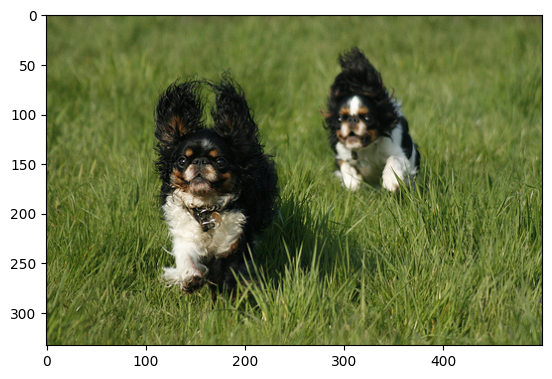

In [50]:
generate_caption(img_test[70])

two black
two dogs run through a field of grass
two fluffy dogs run through the grass
two lookalike dogs running in the green grass
two small dogs run through the grass


('BLEU-4: 0.11868', 'BLEU-3: 0.2772', 'BLEU-2: 0.33333', 'BLEU-1: 0.5')
Predicted caption : 
the black and white dog is running through the grass .


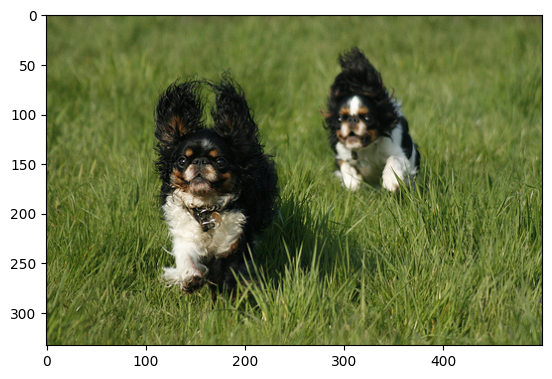

In [49]:
generate_caption_beam_search(img_test[70])

a pitbull dog is biting another dog on the face
a tan dog opens his mouth to bite another tan dog
one dog is trying to bite another
one tag dog biting another tan dog while laying on a bed
two brown dogs playing with each other


('BLEU-4: 0.11922', 'BLEU-3: 0.30053', 'BLEU-2: 0.4264', 'BLEU-1: 0.66667')
Predicted caption : 
a dog is laying on a brown dog with its tongue out .


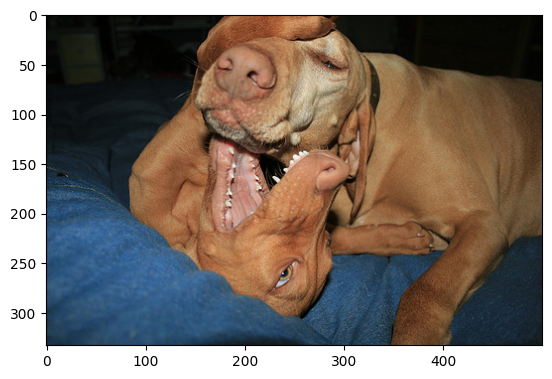

In [51]:
generate_caption(img_test[89])

a pitbull dog is biting another dog on the face
a tan dog opens his mouth to bite another tan dog
one dog is trying to bite another
one tag dog biting another tan dog while laying on a bed
two brown dogs playing with each other


('BLEU-4: 0.09193', 'BLEU-3: 0.18444', 'BLEU-2: 0.46291', 'BLEU-1: 0.75')
Predicted caption : 
a brown dog is laying on its back .


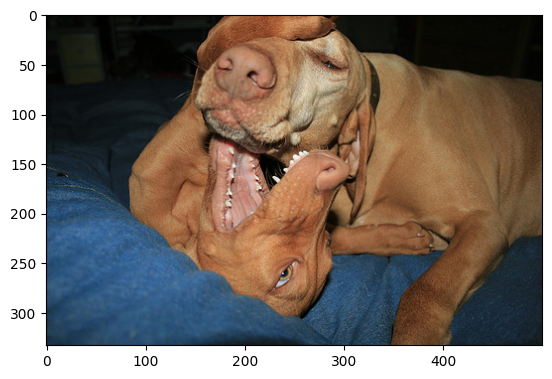

In [52]:
generate_caption_beam_search(img_test[89])

a cluster of four brown dogs play in a field of brown grass
four dogs are together in the field of dry grass
four dogs in a grassy area
four mediumsized dogs wrestle with each other on a grass field
four small dogs play outside


('BLEU-4: 0.01925', 'BLEU-3: 0.03763', 'BLEU-2: 0.0', 'BLEU-1: 0.375')
Predicted caption : 
a large brown dog and a large brown dog are playing with a large brown dog .


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


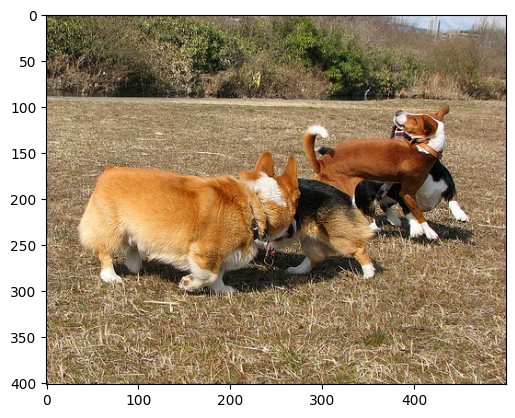

In [37]:
generate_caption(img_test[10])

a cluster of four brown dogs play in a field of brown grass
four dogs are together in the field of dry grass
four dogs in a grassy area
four mediumsized dogs wrestle with each other on a grass field
four small dogs play outside


('BLEU-4: 0.18092', 'BLEU-3: 0.4156', 'BLEU-2: 0.56695', 'BLEU-1: 0.75')
Predicted caption : 
two dogs are playing in a grassy field .


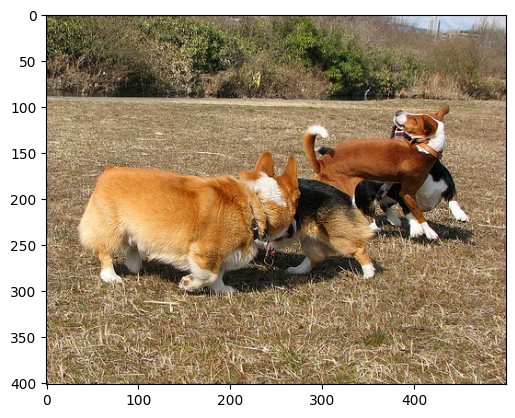

In [53]:
generate_caption_beam_search(img_test[10])